# Learning experiments
Let's find the best parameters to train this bad boy.


In [2]:
import numpy as np
from league_training import LeagueTrainer
from agent_network import Agent, AgentNonMasking
from ppo import PPOTrainer
from scenarios import CtfScenarios as scn
from gridworld_ctf import GridworldCtf
import torch
from league_training import duel
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output
import wandb
import time
import itertools
import copy
import pandas as pd
# torch.set_num_threads(torch.get_num_threads())
print(torch.get_num_threads())

8


### 1. Load config

In [3]:
class TrainingConfig():
    def __init__(self):
        #---------- Overall config
        self.wandb_project_name = "MARL-CTF-Learning-Experiments"
        self.exp_name = "learning_exp"
        self.use_wandb_selfplay = False
        self.use_wandb_ppo = False
        self.seed = 42

        #---------- Self-play config
        self.number_of_iterations = 5
        self.number_of_duels = 3
        self.min_learning_rounds = 1
        self.n_opponents_per_ppo_update = 1
        self.n_main_agents = 1
        self.n_coaching_agents = 0
        self.n_league_agents = 0
        self.n_historical_agents = 10
        self.min_agent_winrate = 0.5
        self.min_historical_agent_winrate = 0.25
        self.min_agent_winrate_for_promotion = 1.1
        self.min_agent_iterations_for_replacement = 3
        self.inference_interval = 1
        self.historical_update_interval = 5

        #---------- Environment config
        self.env_config = {
            'GRID_SIZE': 11,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':1},
                1: {'team':1, 'type':0},
                2: {'team':0, 'type':2},
                3: {'team':1, 'type':0},
                # 4: {'team':0, 'type':2},
                # 5: {'team':1, 'type':2},
            },
            'SCENARIO': scn.donut,
            'GAME_STEPS': 500,
            'USE_ADJUSTED_REWARDS': True,
            'HOME_FLAG_CAPTURE': False,
            'MAP_SYMMETRY_CHECK': False,
            'AGENT_TYPE_HP': {
                0: 10,
                1: 8,
                2: 8,
                3: 7
            },
            'AGENT_TYPE_DAMAGE': {
                0: 1,
                1: 0.5,
                2: 0.5,
                3: 1
            },
            'GUARDIAN_DAMAGE_MULTIPLIER': 5.0,
            'VAULT_HP_COST': 1.25
        }

        #---------- PPO Config
        self.n_actions = 9
        self.learning_rate = 0.0003
        self.num_envs = 8
        self.num_steps = 500
        self.total_timesteps = 62500
        self.torch_deterministic = True
        self.cuda = True
        self.wandb_entity = None
        self.parallel_rollouts = True
        self.anneal_lr = False
        self.gae = True
        self.gamma = 0.999
        self.gae_lambda = 0.95
        self.num_minibatches = 4
        self.update_epochs = 4
        self.norm_adv = False
        self.clip_coef = 0.2
        self.clip_vloss = True
        self.ent_coef = 0.01
        self.vf_coef = 0.5
        self.max_grad_norm = 0.5
        self.target_kl = None
        self.device = 'cpu'

        #---------- Metrics config

args = TrainingConfig()

In [4]:
class RandomAgent:
    """
    Agent that chooses random actions.
    """
    def __init__(self):
        pass

    def get_action(self, x, x2, use_action_mask=0):
        action = torch.randint(low=0, high=5, size=(1,))
        return action.item()
    
    def get_action_and_value(self, x, x2, action=None, use_action_mask=False):
        action = torch.randint(low=0, high=5, size=(1,))
        return action, 0, 0, 0

### 2. Train agents

In [5]:
experiment_name = 'Hyperparameter-Testing'
n_runs = 5

parameters = {
    # 'gamma': [0.9, 0.95, 0.99, 0.999],
    # 'gae_lambda': [0.9, 0.95, 0.99, 0.999],
    # 'num_envs': [4, 8, 12]
    'dummy':[0]
}

keys, values = zip(*parameters.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

parameters_to_test = {i: combinations[i] for i in range(len(combinations))}

print(len(parameters_to_test))


1


In [10]:
# Train PPO
use_wandb = False
run_results = defaultdict(list)
run_times = []
train_team1 = True

global_run = 0
for param_key in parameters_to_test.keys():
    start_time = time.perf_counter()
    
    identifier = experiment_name

    # Set attributes and generate new ppo trainer
    for k, v in parameters_to_test[param_key].items():
        identifier += '_' + k + '=' + str(v)
        setattr(args, k, v)

    env = GridworldCtf(**args.env_config)

    dims_data = env.get_env_dims()
    local_grid_dims = dims_data[0]
    local_metadata_dims = dims_data[2]
    n_channels = local_grid_dims[0]

    ppotrainer = PPOTrainer(args, local_grid_dims, local_metadata_dims)

    for r in range(n_runs):
        print(f'Running {identifier}: run={r}, global_run={global_run}')
        # Reset agent and opponent
        # agent = Agent(args.n_actions, n_channels, env.GRID_SIZE, local_metadata_dims[0]).to(args.device)
        agent = AgentNonMasking(args.n_actions, n_channels, env.GRID_SIZE, local_metadata_dims[0]).to(args.device)
        opponent = RandomAgent()

        # Train ppo
        rewards = ppotrainer.train_ppo(args, env, agent, opponent, train_team1=train_team1)
        clear_output()
        run_results[identifier].append(rewards)

        global_run += 1

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    run_times.append(elapsed_time)

    if use_wandb:
        wandb.init(project=args.wandb_project_name,
                    name=identifier,
                    config=vars(args))
        scores = np.mean(np.array(run_results[identifier]), axis=0)
        for score in scores:
            wandb.log({'average_score': score})  
        wandb.finish()


In [11]:
print(run_times)

[1832.2272305829997]


In [12]:
average_rewards = []

for k in run_results.keys():
    last_value_avg = 0
    n_runs = len(run_results[k])
    for v in run_results[k]:
        last_value_avg += v[-1] * 1/n_runs
    average_rewards.append(last_value_avg)

print(average_rewards)
print(parameters_to_test)

parameters_and_results = copy.deepcopy(parameters_to_test)
for i, k in enumerate(parameters_and_results.keys()):
    parameters_and_results[k].update({"avg_reward":average_rewards[i]})

print(parameters_and_results)

[16.949999237060545]
{0: {'dummy': 0}}
{0: {'dummy': 0, 'avg_reward': 16.949999237060545}}


In [7]:

df = pd.DataFrame(parameters_and_results)
df.T

,avg_reward,dummy
0,26.250001,0.0


### 2. Plot the rewards

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


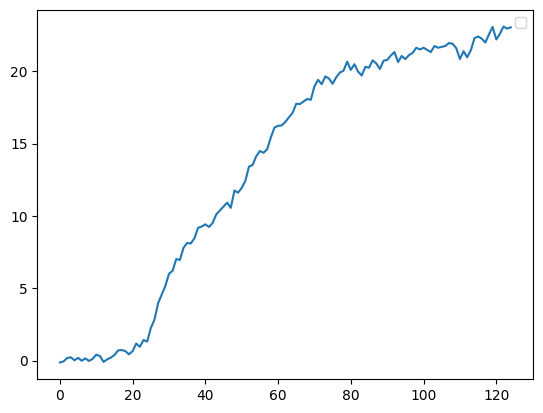

In [9]:
# Compute element-wise averages
run_results_masking = copy.deepcopy(run_results)
averages_masking = {k: np.mean(np.array(v), axis=0) for k, v in run_results_masking.items()}
std_masking = {k: np.std(np.array(v), axis=0) for k, v in run_results_masking.items()}

# Plot rewards
for k, v in averages_masking.items():
    plt.plot(v)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


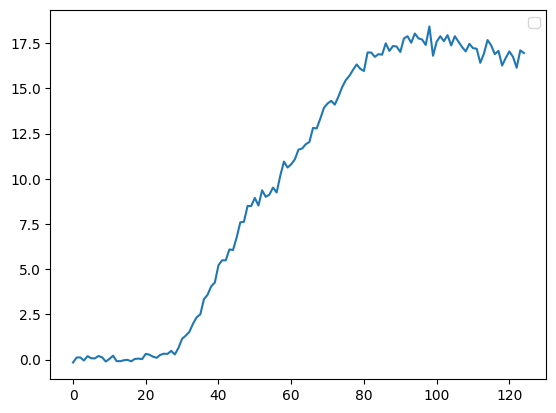

In [13]:
# Compute element-wise averages
run_results_nonmasking = copy.deepcopy(run_results)
averages_nonmasking = {k: np.mean(np.array(v), axis=0) for k, v in run_results_nonmasking.items()}
std_nonmasking = {k: np.std(np.array(v), axis=0) for k, v in run_results_nonmasking.items()}

# Plot rewards
for k, v in averages_nonmasking.items():
    plt.plot(v)
plt.legend()
plt.show()

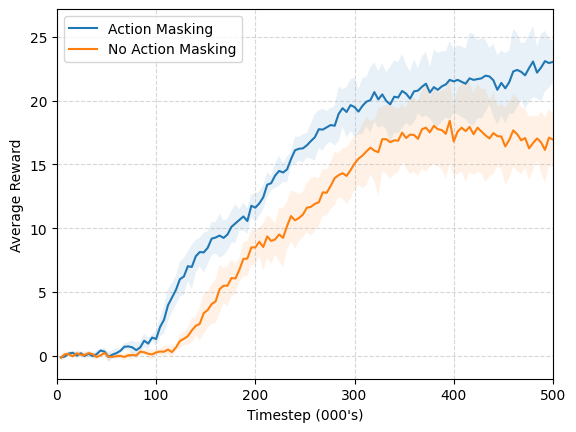

23.04 1.63
16.95 2.1


In [19]:
# Plot rewards
mean_msk = [v for v in averages_masking.values()][0]
mean_nonmsk = [v for v in averages_nonmasking.values()][0]
std_msk = [v for v in std_masking.values()][0]
std_nonmsk = [v for v in std_nonmasking.values()][0]

upper_msk = mean_msk + std_msk
lower_msk = mean_msk - std_msk
upper_nonmsk = mean_nonmsk + std_nonmsk
lower_nonmsk = mean_nonmsk - std_nonmsk

xvals = [(x + 1) * 4 for x in range(len(mean_msk))]

plt.figure()
plt.plot(xvals, mean_msk, label='Action Masking')
plt.plot(xvals, mean_nonmsk, label='No Action Masking')
plt.fill_between(xvals, 
                lower_msk, 
                upper_msk,
                alpha=0.1)
plt.fill_between(xvals, 
                lower_nonmsk, 
                upper_nonmsk,
                alpha=0.1)
plt.grid(linestyle='dashed', alpha=0.5)
plt.xlabel('Timestep (000\'s)')
plt.ylabel('Average Reward')
plt.legend()
plt.xlim([0, 500])
plt.show()


print(round(mean_msk[-1], 2), round(std_msk[-1], 2))
print(round(mean_nonmsk[-1], 2), round(std_nonmsk[-1], 2))

In [20]:
23.04 / 16.95 - 1 

0.35929203539823007

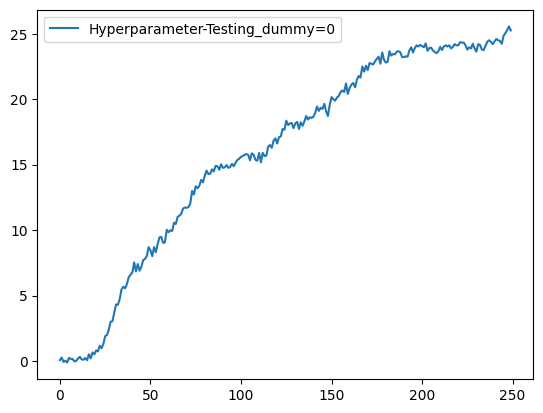

In [10]:
# Compute element-wise averages
averages = {k: np.mean(np.array(v), axis=0) for k, v in run_results.items()}

# Plot rewards
for k, v in averages.items():
    plt.plot(v, label = k)
plt.legend()
plt.show()

In [10]:
averages

{'Hyperparameter-Testing_dummy=0': array([-0.07499999,  0.12500001,  0.07500001,  0.17500001,  0.45500002,
         0.14000001,  0.1       ,  0.53500002,  0.15000001,  0.40500001,
         0.18500001,  0.18      ,  0.36500002,  0.52499999,  0.41500002,
         0.60999999,  0.74999997,  0.82500004,  1.055     ,  1.38499999,
         1.33000004,  1.47499997,  1.89      ,  2.36999996,  2.68499987,
         3.14999995,  4.41000009,  4.88999987,  5.46500015,  6.38999996,
         6.63000011,  8.00999985,  7.71000032,  8.8499999 ,  9.44999981,
        10.53000011, 11.01000004, 11.46000042, 11.90999966, 12.21000023,
        13.41000023, 14.33999996, 14.25000019, 15.4800005 , 15.4800005 ,
        16.41000042, 16.52999954, 16.82999935, 16.50000019, 17.52000008,
        17.70000076, 18.53999977, 18.87000046, 19.01999969, 19.58999901,
        20.01000023, 20.46000023, 20.45999985, 21.02999992, 21.23999977,
        21.75000038, 22.35      , 21.71999969, 22.08000031, 22.79999962,
        22.619999

### 3. Test Trained Policies

In [24]:
def duel(env, agent, opponent, idxs, return_result=False, device='cpu', max_steps=256, render=False, sleep_time=0.01):
    """
    Duelling algorithm.
    """

    step_count = 0
    done = False
    env.reset()

    # Pre-allocate memory for grid_state and metadata_state tensors
    use_action_mask = torch.empty((env.N_AGENTS), dtype=torch.float32, device=device)
    grid_state = torch.empty((env.N_AGENTS, *env.standardise_state(0).shape), dtype=torch.float32, device=device)
    metadata_state = torch.empty((env.N_AGENTS, *env.get_env_metadata(0).shape), dtype=torch.float32, device=device)

    with torch.no_grad():
        while not done:
            step_count += 1

            actions = []

            for agent_idx in np.arange(env.N_AGENTS):
                # Get global and local states
                use_action_mask[agent_idx] = torch.tensor(
                    env.AGENT_TYPE_ACTION_MASK[env.AGENT_TYPES[agent_idx]], 
                    dtype=torch.float32,
                    device=device
                )

                grid_state[agent_idx] = torch.tensor(
                    env.standardise_state(agent_idx, reverse_grid=(env.AGENT_TEAMS[agent_idx] != 0)),
                    dtype=torch.float32,
                    device=device,
                )
                metadata_state[agent_idx] = torch.tensor(
                    env.get_env_metadata(agent_idx),
                    dtype=torch.float32,
                    device=device,
                )

                if env.AGENT_TEAMS[agent_idx] == 0:
                    action = agent.get_action(grid_state[agent_idx], metadata_state[agent_idx], use_action_mask[agent_idx])
                    # action = env.get_reversed_action(action)
                else:
                    action = opponent.get_action(grid_state[agent_idx], metadata_state[agent_idx], use_action_mask[agent_idx])
                    action = env.get_reversed_action(action)

                actions.append(action)

            _, _, done = env.step(actions)

            if render:
                env.render(sleep_time=sleep_time)
                print(step_count, env.metrics['team_flag_captures'][0], env.metrics['team_flag_captures'][1])

            if step_count > max_steps:
                done = True

    if return_result:
        if env.metrics['team_flag_captures'][0] > env.metrics['team_flag_captures'][1]:
            result = 1
        elif env.metrics['team_flag_captures'][0] == env.metrics['team_flag_captures'][1]:
            result = 0
        else:
            result = - 1
        return_metrics = result
    else:
        return_metrics = env.metrics
    
    return idxs[0], idxs[1], return_metrics

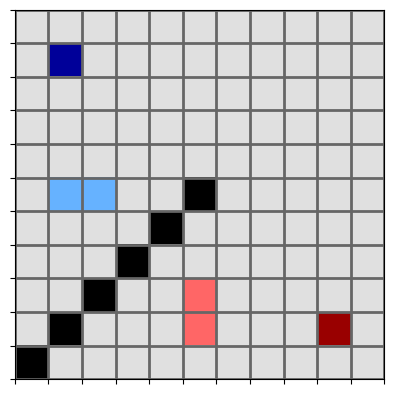

In [25]:
env = GridworldCtf(**args.env_config)
env.render()

In [32]:
env.REVERSED_ACTION_MAP = {
            # Both axis flipped
            None: {
                    0: 1,
                    1: 0,
                    2: 3,
                    3: 2,
                    4: 4,
                    5: 6,
                    6: 5,
                    7: 8,
                    8: 7
            },
            # Vertical axis flipped
            0: {
                    0: 1,
                    1: 0,
                    2: 2,
                    3: 3,
                    4: 4,
                    5: 6,
                    6: 5,
                    7: 7,
                    8: 8
            },
            # Horizontal axis flipped
            1: {
                    0: 0,
                    1: 1,
                    2: 3,
                    3: 2,
                    4: 4,
                    5: 5,
                    6: 6,
                    7: 8,
                    8: 7
            },
            # Diagonal flipped
            2: {
                    0: 2,
                    1: 3,
                    2: 0,
                    3: 1,
                    4: 4,
                    5: 7,
                    6: 8,
                    7: 5,
                    8: 6
            }
        }

# U 0 2
# D 1 3
# R 2 0
# L 3 1
# 0 4 4
# U 5 7
# D 6 8
# R 7 5
# L 8 6

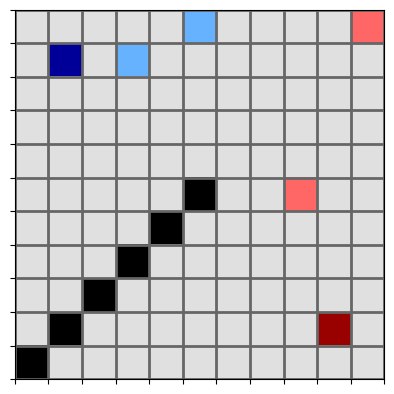

500 11 11


In [33]:
opponent = RandomAgent()
_, _, _ = duel(env, agent, agent, (0, 1), max_steps=1000, render=True, sleep_time=0.01)

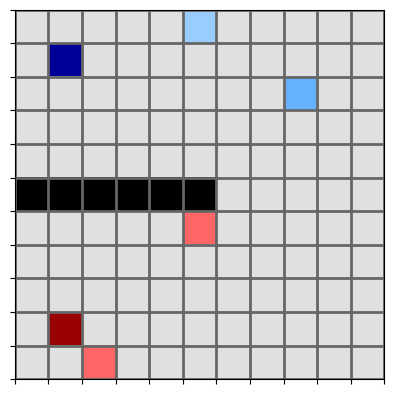

500 0 26


In [17]:
opponent = RandomAgent()
_, _, _ = duel(env, opponent, agent, (0, 1), max_steps=1000, render=True, sleep_time=0.01)

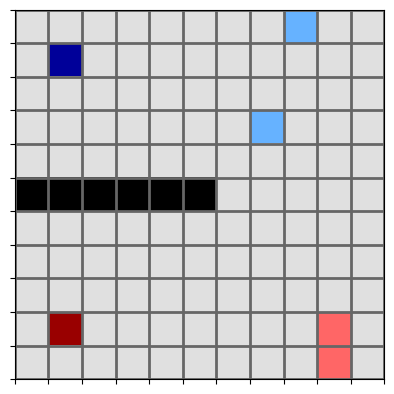

Move 53
reward: 0
flag captures: 1
hp: 8
done: False
Game exited


In [11]:
env = GridworldCtf(**args.env_config)
env.play(0)